In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
plt.style.use("ggplot")

In [7]:
sub = pd.read_csv("data/shuffled_with_txt.csv", usecols=["LON", "LAT", "country"])
sub.head()

,LON,LAT,country
0,-0.867342,47.061554,france
1,13.659586,45.755054,italy
2,2.228794,44.769267,france
3,-4.105137,43.367955,spain
4,-7.287278,42.846748,spain


In [8]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56182842 entries, 0 to 56182841
Data columns (total 3 columns):
LON        float64
LAT        float64
country    object
dtypes: float64(2), object(1)
memory usage: 1.3+ GB


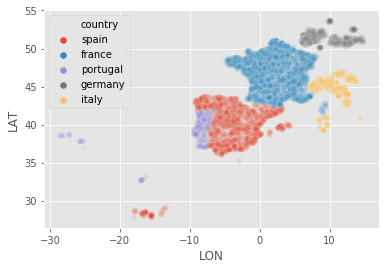

In [9]:
sns.scatterplot(data=sub.sample(10_000).query("LAT > 20"), 
                x="LON", y='LAT', hue='country', alpha=0.1) ;

In [2]:
from sklearn.ensemble import RandomForestClassifier as RfSk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def fit_predict_sk(clf, df):
    X = df[['LON', 'LAT']]
    y = LabelEncoder().fit_transform(df["country"])
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

In [3]:
MAX_ROWS = 58373613
all_lengths = np.logspace(3, np.log10(MAX_ROWS), 6)
clf = RfSk(50)

In [4]:
def benchmark_sk(all_lengths):
    all_durations_sk = dict()
    for nrows in all_lengths:
        nrows = int(nrows)
        df = pd.read_csv("data/shuffled_with_txt.csv", nrows=nrows, 
                        usecols=["LAT", "LON", "country"])

        start = time.time()
        y_pred = fit_predict_sk(clf, df)
        end = time.time()

        duration_sk = end - start
        print(nrows, ':', duration_sk / 60)
        all_durations_sk[nrows] = duration_sk
    return all_durations_sk

In [5]:
all_durations_sk = benchmark_sk(all_lengths)

1000 : 0.0019617080688476562
8979 : 0.005294191837310791
80628 : 0.05562053124109904
723985 : 0.9806118289629618
6500896 : 14.575771335760752
58373613 : 160.97480155626934


In [ ]:
last_duration.values()

In [ ]:
sub.info()

In [ ]:
def plot_regions(clf, X, h=0.2, cm=plt.cm.RdBu):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    
plot_regions(clf, 
             sub.query("LAT > 20")[["LON", "LAT"]].values)

# Spark

In [6]:
import findspark
findspark.init("/home/horace/spark-2.4.4-bin-hadoop2.7")

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [11]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler

def create_pipeline(df):
    label_indexer = StringIndexer(inputCol="country", outputCol="label", handleInvalid="skip").fit(df)
    label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                                   labels=label_indexer.labels)
    assembler = VectorAssembler(
        inputCols=["LON", "LAT"],
        outputCol="features")

    rf = RandomForestClassifier(numTrees=50, 
                                maxDepth=2, 
                                labelCol="label", 
                                seed=42)

    pipeline = Pipeline(stages=[
        label_indexer, 
        assembler,
        rf,
        label_converter
    ])
    return pipeline

In [12]:
def fit_predict(pipeline, df):
    model = pipeline.fit(df)
    predictions = model.transform(df)
    evaluator = MulticlassClassificationEvaluator(
        labelCol='label', predictionCol='prediction', metricName='accuracy'
    )
    accuracy = evaluator.evaluate(predictions)
    print("accuracy: ", accuracy)
    return predictions

In [13]:
all_durations_spark = dict()
for nrows in all_lengths:
    nrows = int(nrows)
    df = spark.read.option("header","true").csv("data/shuffled_with_txt.csv").limit(nrows)
    df = df.withColumn("LAT", df["LAT"].cast("double")).withColumn("LON", df["LON"].cast("double"))
    
    pipeline = create_pipeline(df)
    start = time.time()
    predictions = fit_predict(pipeline, df)
    end = time.time()

    duration_spark = end - start
    all_durations_spark[nrows] = duration_spark
    print(nrows, ':', duration_spark / 60)

accuracy:  0.785
1000 : 1.8560646375020344
accuracy:  0.7839403051564762
8979 : 1.8128689964612326
accuracy:  0.7695961700649898
80628 : 1.8968069116274515
accuracy:  0.7814056921068807
723985 : 2.5805121660232544
accuracy:  0.7677327863728323
6500896 : 8.796940855185191
accuracy:  0.7755238116207046
58373613 : 44.176670793692274


In [ ]:
start = time.time()
predictions = fit_predict(pipeline, df)
end = time.time()

duration = end - start
print(duration)

In [18]:
duration / 60

NameError: name 'duration' is not defined

In [14]:
spark.stop()

# Comparison plots

In [15]:
plt.style.use('ggplot')

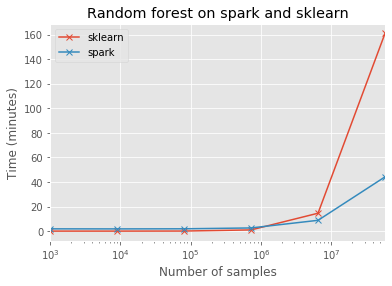

In [34]:
df = pd.DataFrame({'sklearn': all_durations_sk, 
              'spark': all_durations_spark}) / 60

ax = df.plot(marker='x', logx=True)
plt.xlabel("Number of samples")
plt.ylabel("Time (minutes)")
plt.title("Random forest on spark and sklearn")
fig = ax.get_figure()

fig.savefig("benchmark_rf_full.png")

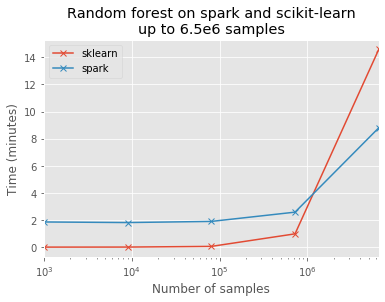

In [33]:
ax = df.iloc[:-1].plot(logx=True, marker='x')

plt.xlabel("Number of samples")
plt.ylabel("Time (minutes)")
plt.title("Random forest on spark and scikit-learn\nup to 6.5e6 samples")
fig = ax.get_figure()

fig.savefig("benchmark_rf_10^7.png")

In [30]:
all_lengths

array([1.00000000e+03, 8.97931723e+03, 8.06281379e+04, 7.23985628e+05,
       6.50089662e+06, 5.83736130e+07])

In [101]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

dataset = txt_df
TfidfTransformer()
tfidf = TfidfVectorizer(max_features=5000)
vect = tfidf.fit_transform(txt_df["STREET"].dropna().values)
vect

<930762x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2028032 stored elements in Compressed Sparse Row format>

In [102]:
tfidf.vocabulary_

{'rue': 4165,
 'du': 1616,
 'chêne': 1188,
 'bo': 671,
 'lg': 2693,
 'pq': 3790,
 'avenue': 412,
 'de': 1504,
 'cl': 1217,
 'medio': 3028,
 'camille': 883,
 'saint': 4205,
 'saëns': 4276,
 'alain': 114,
 'le': 2659,
 'bourg': 733,
 'av': 405,
 'combatentes': 1283,
 'cr': 1412,
 'la': 2594,
 'plateau': 3710,
 'grande': 2185,
 'bombeiros': 688,
 'voluntarios': 4894,
 'docteur': 1576,
 'michel': 3080,
 'lotissement': 2777,
 'colon': 1276,
 'abaran': 46,
 'es': 1729,
 'quintana': 3901,
 'da': 1478,
 'via': 4787,
 'gabriel': 2026,
 'peri': 3594,
 'agosto': 86,
 'chemin': 1152,
 'perrier': 3598,
 'savoie': 4275,
 'estr': 1775,
 'cruz': 1438,
 'waldstraße': 4908,
 'las': 2639,
 'escuelas': 1741,
 'martinez': 2966,
 'campos': 901,
 'limousin': 2710,
 'route': 4150,
 'des': 1535,
 'mines': 3101,
 'barry': 506,
 'grand': 2183,
 'pont': 3751,
 'bretagne': 767,
 'ds': 1615,
 'miguel': 3088,
 'hernandez': 2320,
 'petit': 3610,
 'vau': 4717,
 'tomas': 4564,
 'ponte': 3752,
 'guimar': 2247,
 'allã': 

In [98]:
txt_df[["STREET"]]

,STREET
0,rue du chêne
1,NaN
2,lauressergues
3,BO VILLAPRESENTE
4,LG BERSELOS - PQ BERSELOS
...,...
999995,CL GENERAL BENAVENT GARCIA
999996,CL MATEO SAGASTA
999997,VIA GIUSEPPE GALLIANO
999998,CL RAPIQUERAS (VILLABLINO)
